In [ ]:
import pandas as pd

# ✅ Load your uploaded CSV file with correct encoding
df = pd.read_csv("/content/data.csv", encoding='ISO-8859-1')

# ✅ Show first 5 rows to confirm successful loading
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
import pandas as pd

# ✅ Load your uploaded CSV file with correct encoding
df = pd.read_csv("/content/data.csv", encoding='ISO-8859-1')

# ✅ Show first 5 rows to confirm successful loading
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
import datetime as dt

# ✅ Ensure InvoiceDate is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# ✅ Step 1: Create Revenue column
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# ✅ Step 2: Set snapshot date
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# ✅ Step 3: Create RFM features
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'Revenue': 'sum'                                           # Monetary
}).reset_index()

# ✅ Step 4: Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Revenue': 'Monetary'
}, inplace=True)

# ✅ Step 5: Preview
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [ ]:
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [ ]:
rfm.columns


Index(['CustomerID', 'Recency', 'Frequency', 'Monetary'], dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Features and target
X = rfm[['Recency', 'Frequency']]
y = rfm['Monetary']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")


✅ MAE: 1459.05
✅ RMSE: 7710.63


In [ ]:
# Predict LTV for all customers
rfm['Predicted_LTV'] = model.predict(X)

# Segmenting


In [ ]:
# Define segmentation logic
def segment_customer(ltv):
    if ltv >= 3000:
        return 'High Value'
    elif ltv >= 1000:
        return 'Medium Value'
    else:
        return 'Low Value'

# Apply segmentation
rfm['Segment'] = rfm['Predicted_LTV'].apply(segment_customer)

# Preview
rfm[['CustomerID', 'Predicted_LTV', 'Segment']].head()


,CustomerID,Predicted_LTV,Segment
0,12346.0,155.298032,Low Value
1,12347.0,2745.611183,Medium Value
2,12348.0,1380.977283,Medium Value
3,12349.0,459.152869,Low Value
4,12350.0,406.266846,Low Value


In [ ]:
rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Predicted_LTV', 'Segment']].to_csv("ltv_predictions.csv", index=False)


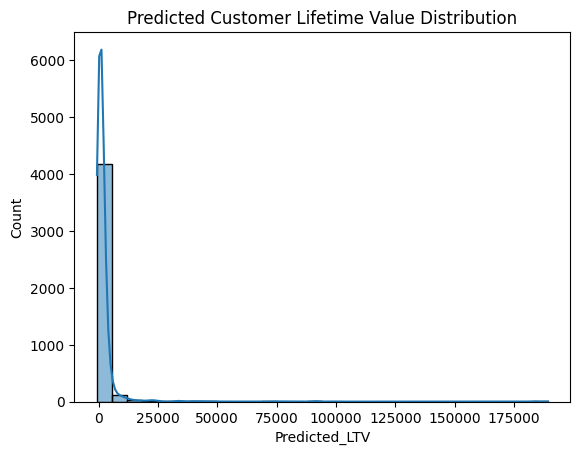

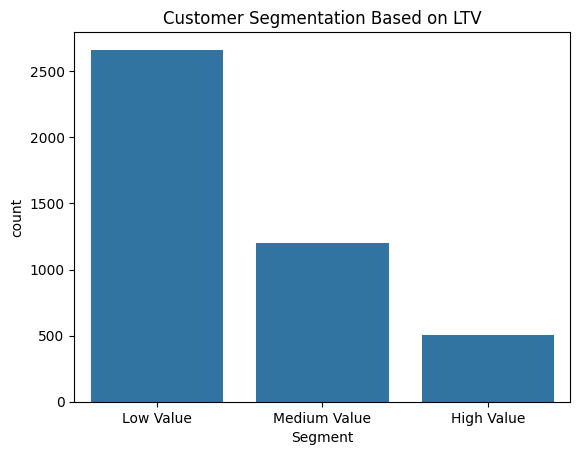

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Predicted LTV
sns.histplot(rfm['Predicted_LTV'], bins=30, kde=True)
plt.title("Predicted Customer Lifetime Value Distribution")
plt.show()

# Count of customers per segment
sns.countplot(data=rfm, x='Segment', order=['Low Value', 'Medium Value', 'High Value'])
plt.title("Customer Segmentation Based on LTV")
plt.show()
